# 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


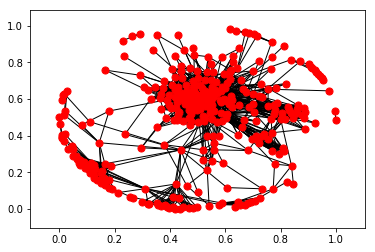

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

# 2. Train Graph VAE

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Tensorflow Settings (hyperparams) - ONLY RUN THIS CELL ONCE
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_vae', 'Model string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

In [31]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [32]:
# Graph attributes
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [33]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

In [34]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [35]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [39]:
# Create VAE model
with tf.name_scope('optimizer'):
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

    opt = OptimizerVAE(preds=vae.reconstructions,
                               labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                           validate_indices=False), [-1]),
                               model=model, num_nodes=num_nodes,
                               pos_weight=pos_weight,
                               norm=norm)

In [40]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score


cost_val = []
acc_val = []
val_roc_score = []

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [41]:
# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.71639 train_acc= 0.49322 val_roc= 0.79418 val_ap= 0.79834 time= 0.09241
Epoch: 0002 train_loss= 1.57170 train_acc= 0.49396 val_roc= 0.79322 val_ap= 0.79624 time= 0.02176
Epoch: 0003 train_loss= 1.38861 train_acc= 0.48705 val_roc= 0.80864 val_ap= 0.80673 time= 0.02185
Epoch: 0004 train_loss= 1.33792 train_acc= 0.48439 val_roc= 0.84902 val_ap= 0.82751 time= 0.02692
Epoch: 0005 train_loss= 1.19660 train_acc= 0.48439 val_roc= 0.76826 val_ap= 0.72394 time= 0.02375
Epoch: 0006 train_loss= 1.08436 train_acc= 0.45482 val_roc= 0.62445 val_ap= 0.61606 time= 0.02897
Epoch: 0007 train_loss= 0.95421 train_acc= 0.42844 val_roc= 0.62387 val_ap= 0.60118 time= 0.03573
Epoch: 0008 train_loss= 0.90593 train_acc= 0.39772 val_roc= 0.61072 val_ap= 0.57151 time= 0.03261
Epoch: 0009 train_loss= 0.81185 train_acc= 0.39354 val_roc= 0.61200 val_ap= 0.56016 time= 0.03650
Epoch: 0010 train_loss= 0.72754 train_acc= 0.41311 val_roc= 0.62080 val_ap= 0.55619 time= 0.03886
Epoch: 0011 train_lo

Epoch: 0088 train_loss= 0.46608 train_acc= 0.59590 val_roc= 0.50800 val_ap= 0.75202 time= 0.04576
Epoch: 0089 train_loss= 0.46507 train_acc= 0.60279 val_roc= 0.50800 val_ap= 0.75202 time= 0.04177
Epoch: 0090 train_loss= 0.46619 train_acc= 0.60000 val_roc= 0.50800 val_ap= 0.75202 time= 0.03629
Epoch: 0091 train_loss= 0.46565 train_acc= 0.59563 val_roc= 0.50800 val_ap= 0.75202 time= 0.04883
Epoch: 0092 train_loss= 0.46605 train_acc= 0.59056 val_roc= 0.50800 val_ap= 0.75202 time= 0.03595
Epoch: 0093 train_loss= 0.46483 train_acc= 0.59417 val_roc= 0.50800 val_ap= 0.75202 time= 0.02549
Epoch: 0094 train_loss= 0.46536 train_acc= 0.60079 val_roc= 0.50800 val_ap= 0.75202 time= 0.03734
Epoch: 0095 train_loss= 0.46507 train_acc= 0.59502 val_roc= 0.50800 val_ap= 0.75202 time= 0.03403
Epoch: 0096 train_loss= 0.46426 train_acc= 0.60110 val_roc= 0.50800 val_ap= 0.75202 time= 0.02786
Epoch: 0097 train_loss= 0.46453 train_acc= 0.59255 val_roc= 0.50800 val_ap= 0.75202 time= 0.02643
Epoch: 0098 train_lo

Epoch: 0179 train_loss= 0.44773 train_acc= 0.61042 val_roc= 0.50800 val_ap= 0.75202 time= 0.02289
Epoch: 0180 train_loss= 0.44734 train_acc= 0.60883 val_roc= 0.50800 val_ap= 0.75202 time= 0.02714
Epoch: 0181 train_loss= 0.44722 train_acc= 0.61201 val_roc= 0.50800 val_ap= 0.75202 time= 0.02686
Epoch: 0182 train_loss= 0.44734 train_acc= 0.61179 val_roc= 0.50800 val_ap= 0.75202 time= 0.02248
Epoch: 0183 train_loss= 0.44695 train_acc= 0.61477 val_roc= 0.50800 val_ap= 0.75202 time= 0.02454
Epoch: 0184 train_loss= 0.44700 train_acc= 0.61219 val_roc= 0.50800 val_ap= 0.75202 time= 0.02344
Epoch: 0185 train_loss= 0.44688 train_acc= 0.60853 val_roc= 0.50800 val_ap= 0.75202 time= 0.02361
Epoch: 0186 train_loss= 0.44694 train_acc= 0.60916 val_roc= 0.50800 val_ap= 0.75202 time= 0.02586
Epoch: 0187 train_loss= 0.44671 train_acc= 0.60817 val_roc= 0.50800 val_ap= 0.75202 time= 0.02690
Epoch: 0188 train_loss= 0.44662 train_acc= 0.61583 val_roc= 0.50800 val_ap= 0.75202 time= 0.03114
Epoch: 0189 train_lo